In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
import yfinance as yf

from pprint import pprint
from sklearn.preprocessing import StandardScaler

In [ ]:
# Hyperparamter
# Define the assets
assets = ['AAPL', 'DIS', 'GC=F', 'META']
number_of_stocks = len(assets)

# Define start date
start_date = '2015-01-01'

In [ ]:
# Fetch the data
data = yf.download(assets, start_date)['Adj Close']
data = round(data,3)

# Print first 5 rows of the data
print(data.head())
print(type(data))

[*********************100%***********************]  4 of 4 completed
              AAPL     DIS    GC=F   META
Date                                     
2015-01-02  24.566  87.376  1186.0  78.45
2015-01-05  23.874  86.099  1203.9  77.19
2015-01-06  23.876  85.643  1219.3  76.15
2015-01-07  24.211  86.519  1210.6  76.15
2015-01-08  25.141  87.414  1208.4  78.18
<class 'pandas.core.frame.DataFrame'>


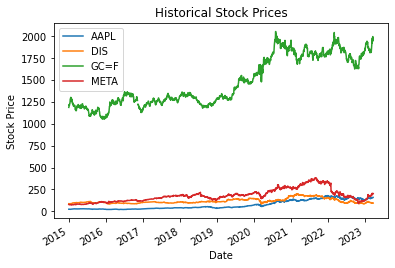

In [ ]:
%matplotlib inline

(data[assets]).plot()

plt.title('Historical Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')

plt.show()

In [ ]:
def get_sharp_ratio(data, weights):
  # Calculate the Log of returns.
  log_return = np.log(data / data.shift(1))

  # Calculate the Annualized Expected Returns
  NUM_OF_DAYS = 252
  exp_return = np.dot(weights, log_return.mean() * NUM_OF_DAYS)

  # Calculate the Annualized Expected Volatility
  exp_vol = np.sqrt(np.dot(weights.T, np.dot(log_return.cov() * 252, weights)))

  # Calculate the Sharpe Ratio
  sharpe_ratio = exp_return / exp_vol

  return (exp_return, exp_vol, sharpe_ratio)

In [ ]:
def get_random_weights(number_of_stocks):
  # Generate Random Weights.
  random_weights = np.array(np.random.random(number_of_stocks))

  # Make sure weights sum up to 1
  init_weights = random_weights / np.sum(random_weights)
  return init_weights

In [ ]:
def monte_carlo_simulations(data, num_of_iter):
  # Initialization
  all_weights = np.zeros((num_of_iter, number_of_stocks))
  return_arr = np.zeros(num_of_iter)
  vol_arr = np.zeros(num_of_iter)
  sharpe_arr = np.zeros(num_of_iter)

  # Simulations
  for i in range(num_of_iter):
    weights = get_random_weights(number_of_stocks)
    all_weights[i, :] = weights

    exp_return, exp_vol, sharpe_ratio = get_sharp_ratio(data, weights)
    return_arr[i] = exp_return
    vol_arr[i] = exp_vol
    sharpe_arr[i] = sharpe_ratio
  

  simulations_data = [return_arr, vol_arr, sharpe_arr, all_weights]
  simulations_df = pd.DataFrame(data=simulations_data).T

  simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
  ]

  simulations_df = simulations_df.infer_objects()
  return simulations_df

In [ ]:
np.random.seed(42)

simulations_df = monte_carlo_simulations(data, 1000)
simulations_df.head()

,Returns,Volatility,Sharpe Ratio,Portfolio Weights
0,0.082241,0.190196,0.432402,"[0.1410215567872302, 0.3579622176722185, 0.275..."
1,0.118065,0.310385,0.380383,"[0.12620080734580005, 0.12618129700478345, 0.0..."
2,0.115325,0.267473,0.431163,"[0.26139050028350513, 0.3079002216404562, 0.00..."
3,0.162297,0.232573,0.697831,"[0.5903801501374071, 0.15059391470113248, 0.12..."
4,0.090332,0.186552,0.484218,"[0.1960105449641472, 0.33807860847040766, 0.27..."


In [ ]:
def get_max_sharpe_ratio(df):
  return df.loc[df['Sharpe Ratio'].idxmax()]

def get_min_volatility(df):
  return df.loc[df['Volatility'].idxmin()]

print(get_max_sharpe_ratio(simulations_df))
print(get_min_volatility(simulations_df))

Returns                                                       0.134895
Volatility                                                    0.154053
Sharpe Ratio                                                   0.87564
Portfolio Weights    [0.4087945008923314, 0.0038573348687276202, 0....
Name: 475, dtype: object
Returns                                                        0.07159
Volatility                                                    0.130812
Sharpe Ratio                                                   0.54727
Portfolio Weights    [0.07641406836395452, 0.2075987639640013, 0.64...
Name: 283, dtype: object


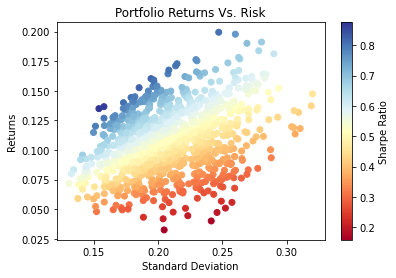

In [ ]:
# This is so I can see the plot inside of my Jupyter Notebook.
%matplotlib inline

# Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

# Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

# Finally, show the plot.
plt.show()

# Maximize Sharpe Ratio

In [ ]:
constraints = ({'type' : 'eq', 'fun': lambda x: np.sum(x) -1})
bounds = tuple((0,1) for x in range(number_of_stocks))
initializer = number_of_stocks * [1./number_of_stocks,]

print (initializer)
print (bounds)

[0.25, 0.25, 0.25, 0.25]
((0, 1), (0, 1), (0, 1), (0, 1))


In [ ]:
def minimize_sharpe(weights):  
    return -get_sharp_ratio(data, weights)[2]

def minimize_volatility(weights):  
    return get_sharp_ratio(data, weights)[1]

In [ ]:
import scipy.optimize as optimize

optimal_sharpe = optimize.minimize(minimize_sharpe,
                                 initializer,
                                 method = 'SLSQP',
                                 bounds = bounds,
                                 constraints = constraints)
print("max sharpe ratio", get_sharp_ratio(data, optimal_sharpe.x)[2])
print("expected return", get_sharp_ratio(data, optimal_sharpe.x)[0])
print("optimal weight for max sharpe ratio:", optimal_sharpe.x)
print("max sharpe ratio derived from monte carlo simulation:", get_max_sharpe_ratio(simulations_df)["Sharpe Ratio"])

max sharpe ratio 0.8883120639152506
expected return 0.14312363124508606
optimal weight for max sharpe ratio: [4.66118449e-01 1.68196804e-16 5.33881551e-01 0.00000000e+00]
max sharpe ratio derived from monte carlo simulation: 0.875640010510749


In [ ]:
optimal_volatility = optimize.minimize(minimize_volatility,
                                 initializer,
                                 method = 'SLSQP',
                                 bounds = bounds,
                                 constraints = constraints)

print("min volatility", get_sharp_ratio(data, optimal_volatility.x)[1])
print("expected return", get_sharp_ratio(data, optimal_volatility.x)[0])
print("optimal weight for min volatility:", optimal_volatility.x)
print("min volatility derived from monte carlo simulation:", get_min_volatility(simulations_df)["Volatility"])

min volatility 0.12719775171849526
expected return 0.07555356325785158
optimal weight for min volatility: [0.09654898 0.14624177 0.73566611 0.02154314]
min volatility derived from monte carlo simulation: 0.13081225471627683


In [ ]:
def get_percentage_increase(cur_rate):
  BASELINE_RATE = 0.0457
  return round((cur_rate - BASELINE_RATE) / BASELINE_RATE, 3) * 100

In [ ]:
print("Expected Return rate of Maximum Sharpe Ratio compared to baseline rate", get_percentage_increase(0.14312363124508606), "%")
print("Expected Return rate of Minimum Volatility compared to baseline rate", get_percentage_increase(0.07555356325785158), "%")

Expected Return rate of Maximum Sharpe Ratio compared to baseline rate 213.20000000000002 %
Expected Return rate of Minimum Volatility compared to baseline rate 65.3 %


#Conclusion

Compare to the Risk-Free Rate of Return, (3 Month Treasury Bill Rate -- 4.57%):

*   Expected Return rate of Maximum Sharpe Ratio -- 14.3% (increased 213%)
*   Expected Return rate of Minimum Volatility -- 7.55% (increased 65.3%)



Thanks for reading :)